<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_dclink_current_Spectrum_varyingModulationIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pulse Width Modulation - The Spectrum of DC Link Current with Varying Modulation Index</h1></b>

Dr. Bingsen Wang

10/26/2024
</center>

#Python Code

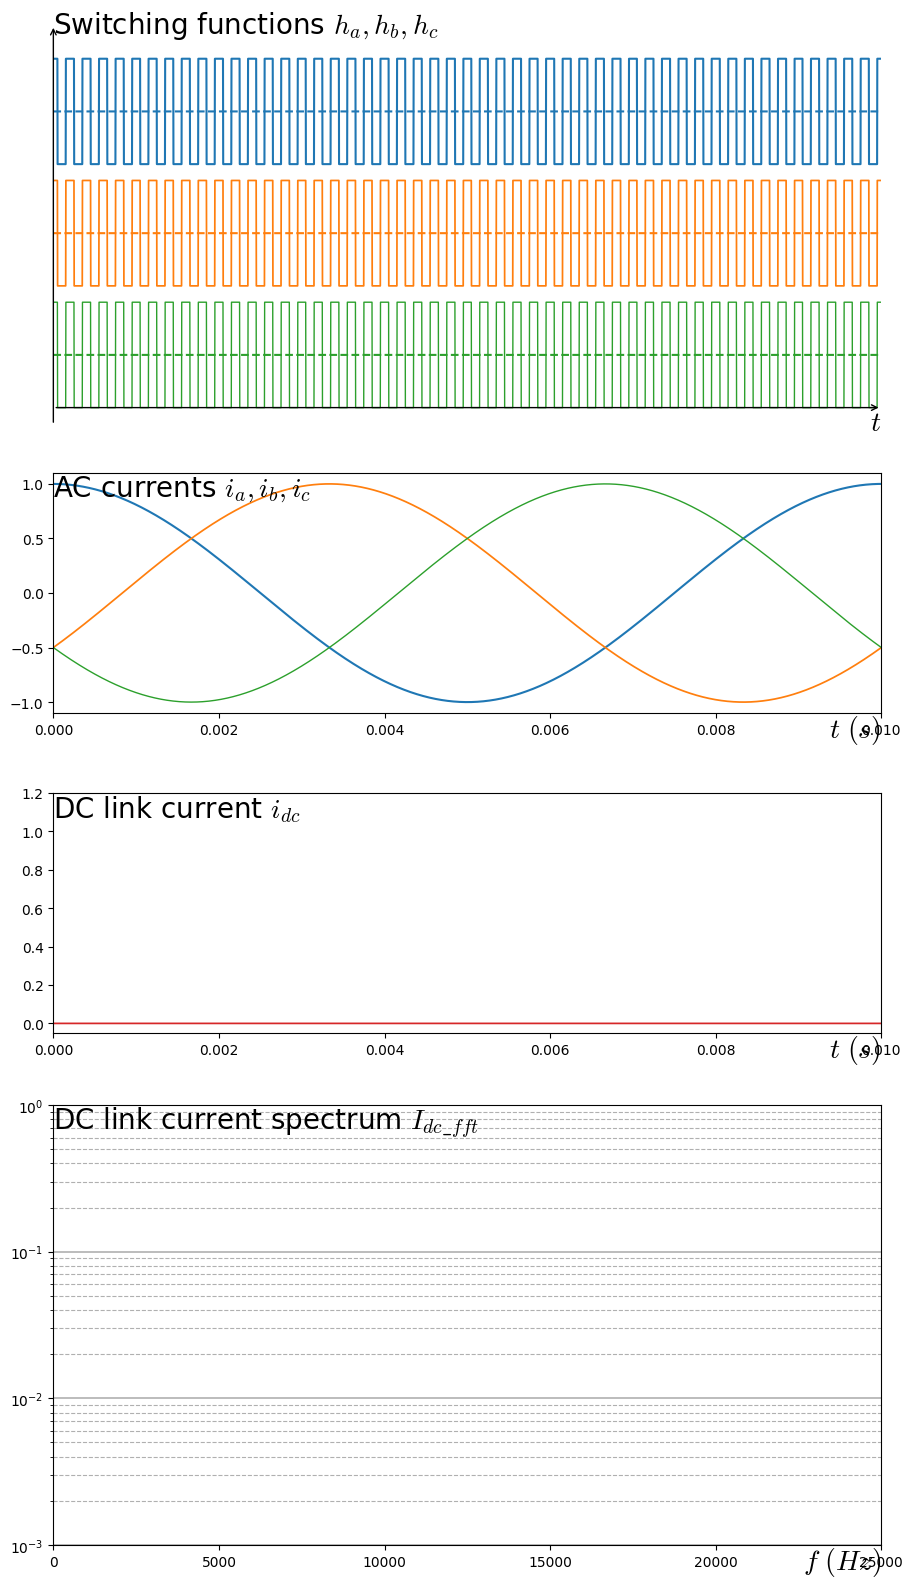

In [45]:
from os import linesep
import numpy as np
from numpy import linspace,logspace,cos,sin,pi,exp,heaviside,arccos,fft,angle,abs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams.update({'font.family':"sans serif",'animation.html':'jshtml',
                     'mathtext.fontset':'cm'})
#functions
def carr(t,f): #carrier
  return 1/pi*arccos(cos(2*pi*f*t))

def m(t,k,MI,f,theta): #modulation function
  return (MI*cos(2*pi*f*t - 2*pi/3*k + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

def spectrum(xt): #spectrum - magnitude and angle
  xfft = fft.rfft(xt)
  xfft_angle = angle(xfft)
  xfft_mag = abs(xfft)/len(xt)*2
  xfft_mag[0]=xfft_mag[0]*0.5 #adjust the dc component
  return xfft_mag,xfft_angle

#parameters
Nf = 100 # number of frames
fm = 100 # modulation frequency
fc = 50*fm # carrier frequency
MI = 0.9 # modulation index
Np = 4096 # number of points for time series
phi = 0 #phase series
MI_lst = linspace(0,1,Nf) #modulation index series
#time series
t=linspace(0,1/fm,Np)
fser = linspace(0,int(Np/2),int(Np/2)+1)#frequency series
ct = carr(t,fc) #carrier time-domain signal

#set up figures
fig = plt.figure(figsize=(9,16))
fig.tight_layout()
ax_frame = [
            [[.05,.7, .92,.25], [0,1/fm], [-.05,1.1]], # switching waveforms
            [[.05,.52,.92,.15], [0,1/fm], [-1.1,1.1]], #ac current
            [[.05,.32,.92,.15], [0,1/fm], [-.05,1.2]], # idc current
            [[.05, 0, .92,.275], [0,5*fc], [.001,1]], # idc spectrum
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[
        ['Switching functions $h_a,h_b,h_c$', '$t$'],
        ['AC currents $i_a,i_b,i_c$', '$t\ (s)$'],
        ['DC link current $i_{dc}$','$t\ (s)$'], #yx axes labels
        ['DC link current spectrum $I_{dc\_fft}$','$f\ (Hz)$']] #yx axes labels
clst = list(mpl.cm.tab10.colors) #colors of lines
lines,ax_lst=[],[] #empty lists for lines and axes

for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax_lst.append(ax)
  if k<1:
    ax.axis('off') #turn off axis frames
    ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
    ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
    ax.text(xm,0,ax_lbl[k][-1],size=20, va='top', ha='right') #x-axis label
    y_text=ax.text(0,ym,ax_lbl[k][0], size=20, va='center') #y-axis label
    for kk in range(3):
      lines.append(ax.plot([], [], lw=1.5-.25*kk,color=clst[kk])[0]) #ha,b,c
      lines.append(ax.plot([], [], lw=1.5,ls='--',color=clst[kk])[0]) #ma,b,c
  else:
    y_text=ax.text(0,ym,ax_lbl[k][0], size=20, va='top') #y-axis label
    ax.text(xm,yn,ax_lbl[k][-1],size=20, va='top', ha='right') #x-axis label
    if k==1:
      for kk in range(3):
        lines.append(ax.plot([], [], lw=1.5-.25*kk,color=clst[kk])[0]) #ia,b,c
    else:
      lines.append(ax.plot([], [], lw=1.25,color=clst[k+1])[0]) #switching functions
line_spectr = ax_lst[3].plot([], [], color=clst[5], ls='-',lw=1, marker='x',
                             ms=7,mec=clst[3])[0] #spectrum
ax_lst[3].set_yscale('log')
ax_lst[3].grid(which='major', axis='y', linestyle='-', lw=1.2)
ax_lst[3].grid(which='minor', axis='y', linestyle='--', lw=.8)
def animate(i):
  MI=MI_lst[i]
  mt = [m(t,k,MI,fm,phi) for k in range(3)] #modulation time series
  ht = [h(ct,mt[k])/3.3+.35*(2-k) for k in range(3)] #pwm signal time series
  iabc = [cos(2*pi*fm*t-2*pi/3*k) for k in range(3)]
  idc = sum(h(ct,mt[k])*cos(2*pi*fm*t-k*2*pi/3) for k in range(3))
  idc_fft = spectrum(idc)
  for k in range(3):
    lines[2*k].set_data(t,ht[k])
    lines[2*k+1].set_data(t,mt[k]/3.3+.35*(2-k))
    lines[k+6].set_data(t,iabc[k])
  lines[9].set_data(t,idc)
  line_spectr.set_data(fser[:5*fc//fm]*fm,idc_fft[0][:5*fc//fm])
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following line
anim.save("DCLinkCurrentSpectrum_varyingMI.mp4", writer=animation.FFMpegWriter(fps=10), dpi = 200)